# Pursuit-Evasion Game Demo

In this demo, we will:
1. Initialize a pursuit–evasion game (PEG) instance as an example of a stochastic game;
2. Implement a linear-programming solver for static matrix games, which will serve as the building block for our stochastic game solver;
3. Implement the code that generates the Q-matrix at each state;
4. Implement the value update step;
5. Combine Q-matrix generation and value updates into a concise `NashSolver` class;
6. Solve the PEG and visualize the results.

The main purpose is to demonstrate the Nash Solver for Stochastic Games:
```text
Algorithm 1: Stochastic Game Nash Solver
Input: Transition matrix P, reward R
Initialize V ← 0, Q ← 0
repeat
    for each state s do
        Q[s, a1, a2] ← (R[s, a1, a2] + γ * Σ P[s'|s, a1, a2] V[s'])
        V[s] ← MatrixGameNash(Q[s, :, :])
until convergence
return V
```

In [33]:
import numpy as np
from typing import List, Tuple
from scipy.optimize import linprog
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(".")))

### Step 1: Initialize a pursuit-evasion game
- Pursuer maximizes, evader minimizes.
- A reward of +1 is assigned when capture happens, otherwise reward is zero. 
- Occupancy_matrix defines the grid environment with 1 representing obstacles and 0 for free space.
- Capture radius: If the distance between the pursuer and the evader is leq capture radius then the evader is captured.
- Action spaces are the movement vectors. We give the pursuer an advantage by allowing it to move diagonally, so that a capture can be ensured.
- transition_eps denotes for the probability of agent staying at its current position, even when it intends to move. Use for stochastic transitions.

The PEG code is already implemented. 
We can now initialize an instance of a PEG with the following `occupancy_matrix`, where 0 is free space and 1 is obstacle.
While you can change the environment freely, keep in mind that for a large grid size, it may take a while to generate the game due to the construction of the transition and reward matrices.


In [34]:
from game_example.peg import PursuitEvasionGame
occupancy_matrix = np.array([
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
])

peg = PursuitEvasionGame(occupancy_matrix=occupancy_matrix, capture_radius=1, transition_eps=0.2, gamma=0.9)

Initializing Pursuit-Evasion Game...
    Generating rewards for PEG...
    Generating compressed transitions for PEG...
PEG initialized!


Let's visulaize the environment we just implemented!

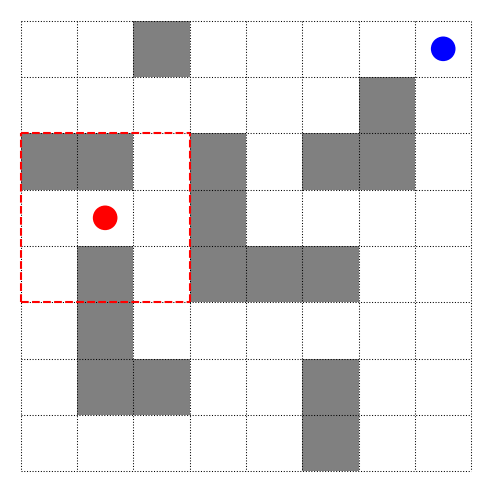

In [36]:
import matplotlib.pyplot as plt
from game_example.animation import peg_animate_per_frame

# visualize pursuer at (0,0) and evader at (7,7)
pos_p, pos_e = (4,1), (7,7)

# initialize plot
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.ioff()
fig, ax = plt.subplots(figsize=(4,4))

peg_animate_per_frame(ax, peg, occupancy_matrix, pos_p, pos_e)
plt.show()


### Step 2: Linear program for a static matrix game

We start with a static zero-sum matrix game with payoff matrix $A \in \mathbb{R}^{m \times n}$.  
The **row player** chooses a mixed strategy $x \in \Delta_m$ and wants to maximize the expected payoff, while the **column player** chooses a mixed strategy $y \in \Delta_n$ and wants to minimize it.

The value of the game is
\begin{equation}
v^\star \;=\; \max_{x \in \Delta_m} \; \min_{y \in \Delta_n} \; x^\top A y.
\end{equation}

We can rewrite the max–min problem as the following **linear program** in the variables $(x, v)$ for the **row player**:

\begin{aligned}
\max_{x, v} \quad & v \\
\text{s.t.} \quad & A^\top x \;\ge\; v \mathbf{1}_n, \\
                  & \mathbf{1}_m^\top x = 1, \\
                  & x \ge 0.
\end{aligned}

Here, $v$ is the game value (the guaranteed payoff for the row player), and $p$ is the optimal mixed strategy over rows.

### Solving linear programs using `scipy.optimize.linprog`

`scipy.optimize.linprog` solves linear programs in the following standard form:

\begin{aligned}
\min_x \quad & c^\top x \\
\text{s.t.} \quad 
& A_{\text{ub}} x \le b_{\text{ub}}, \\
& A_{\text{eq}} x = b_{\text{eq}}, \\
& \ell \le x \le u,
\end{aligned}

where:
- $c \in \mathbb{R}^n$ is the cost vector,
- $A_{\text{ub}} \in \mathbb{R}^{m \times n}$, $b_{\text{ub}} \in \mathbb{R}^m$ define inequality constraints,
- $A_{\text{eq}} \in \mathbb{R}^{k \times n}$, $b_{\text{eq}} \in \mathbb{R}^k$ define equality constraints,
- $\ell, u$ define lower/upper bounds on each variable.

The Python interface is:

```python
from scipy.optimize import linprog

result = linprog(
    c,
    A_ub=A_ub, b_ub=b_ub,
    A_eq=A_eq, b_eq=b_eq,
    bounds=bounds,
    method="highs" 
)
```

The solution is stored in the returned object:
```python
result.x      # optimal decision variables
result.fun    # optimal objective value
```

Now, we can implement the static matrix game solver.

In [37]:
def linprog_solve(payoff_matrix: np.ndarray) -> (float, np.ndarray, np.ndarray):
    '''
    :param payoff_matrix: M X N Matrix. The entry of the jointly selected row and column represents the winnings of the
                          row player and the loss of the column player
                          i.e. row maximizes and column minimizes
    :return: the value of the game, the optimal policy for the row player and the optimal policy for the column player
    '''
    m, n = payoff_matrix.shape[0], payoff_matrix.shape[1]

    
    # Setting up the inputs to the scipy.optimize.linprog
    # Decision variables x1, x2, ..., xn, v
    # Objective is to maximize v, thus objective vector c is 0*y1+0*y2+...+0*yn - v
    
    C = []
    for i in range(n):
        C.append(0)
    C.append(-1)

    
    # Optimality constraints: value_matrix[i_row, :] @ x >= v for all i_row
    A_ub = []
    for i_row in range(m):
        col = payoff_matrix[i_row, :]
        constraint_row = []
        for item in col:
            constraint_row.append(-item)
        constraint_row.append(1)
        A_ub.append(constraint_row)
    B_ub = []
    for i in range(m):
        B_ub.append(0)

    # Probability constraint: x1 + x2 + ... + xn = 1
    A_eq = []
    A_eq_row = []
    for i in range(n):
        A_eq_row.append(1)
    A_eq_row.append(0)
    A_eq.append(A_eq_row)
    B_eq = [1]

    bounds = []
    for i in range(n):
        bounds.append((0, 1))
    bounds.append((None, None))

    # Linprog solves the problem:
    res = linprog(C, A_ub=A_ub, b_ub=B_ub, A_eq=A_eq, b_eq=B_eq, bounds=bounds, method='highs')

    # Col player's policy is retrieved from the x variable
    policy_col = res['x'][:-1]
    for i, p in enumerate(policy_col):
        if p < 0:
            policy_col[i] = 0
    policy_col /= sum(policy_col)

    # Row player's policy is retrieved from the dual variable
    policy_row = -res.ineqlin.marginals

    return -res['fun'], policy_row, policy_col

Let's now quickly test the solver we just implemented. Let's test it on a Rock Paper Scissor problem!

In [38]:
rps_payoff = np.array(
    [[0, 1, -1],
     [-1, 0, 1],
     [1, -1, 0]
    ]
)

rps_value, row_policy, col_policy = linprog_solve(rps_payoff)
print("game value: {}".format(rps_value))
print("row player policy: {}".format(row_policy))
print("col player policy: {}".format(col_policy))

game value: -0.0
row player policy: [0.33333333 0.33333333 0.33333333]
col player policy: [0.33333333 0.33333333 0.33333333]


## Step 3: Construction of Q-matrix
Now we construct the Q-matrix at each state. For Player 1 with n actions and Player 2 with m actions, the Q-matrix should be $n\times m$, and each of its entry is defined as 
\begin{equation}
    Q(s, a^1, a^2) = r(s, a^1, a^2) + \gamma \sum_{s'} P(s'|s,a^1,a^2) V(s').
\end{equation}

In [39]:
def update_Q_s(game, s, value_vector):
    n, m = game.get_n_action1(s), game.get_n_action2(s)
    Q_s = np.zeros((n, m))
    for a1 in range(n):
        for a2 in range(m):
            Q_s[(a1,), (a2,)] = game.get_all_rewards_s(s)
            trans_state_list, trans_prob_list = game.get_compressed_transitions_s(s, a1, a2)
            for s_prime, p in zip(trans_state_list, trans_prob_list):
                Q_s[a1, a2] += game.gamma * p * value_vector[s_prime]
    return Q_s

## Step 4: Computation of Value Function
With the Q-matrix constructed for each state, we can compute the value at each state by simply calling our matrix game solver. 
Formally, we have 
\begin{equation}
    V(s) = \max_{\pi^1} \min_{\pi^2} \big(\pi^1\big)^\top Q \pi^2 = \texttt{linprog\_solve}(Q).
\end{equation}

In [40]:
def update_V_s(Q_s):
    V_s = linprog_solve(Q_s)[0]
    return V_s

## Step 5: Combine Everything into the Nash Solver
Remember, we need to update the Q-matrices and the Values at every state, and then repeat the whole process. 
So, the last thing we need to do is wrapping the $\texttt{update\_Q\_s}$ and $\texttt{update\_V\_s}$ in a for loop that iterates through the states. 
This completes a single iteration in the Nash solver.

In [41]:
def single_update(game, v_vector_old):
    Q_list, v_vector_new = [], np.zeros(game.get_n_states())
    for s in range(game.get_n_states()):
        Q_s = update_Q_s(game=game, s=s, value_vector=v_vector_old)
        Q_list.append(Q_s)
    for s in range(game.get_n_states()):
        v_vector_new[s] = update_V_s(Q_list[s])
    return v_vector_new

Let's now test it with our PEG instance. We will initialize the value vector to be all zeros, and let's see what we get after a single update. 

Specifically, let's check the value at two game states:
1. The Pursuer is at (0, 1) and the Evader is at (0, 0), which corresponds to a capture. We should expect a positive reward for the Pursuer.
2. The Pursuer is at (0, 2) and the Evader is at (0, 0), which corresponds to an imminent capture that hasn't happened yet. 

In [42]:
v_vector_old = np.zeros(peg.get_n_states())
v_vector_new = single_update(peg, v_vector_old)

state_capture = peg.pos2game_state((0,1), (0,0))
print("game value at P (0, 1), E (0,0) is {}".format(v_vector_new[state_capture]))
state_imminent_capture = peg.pos2game_state((0,2), (0,0))
print("game value at P (0, 2), E (0,0) is {}".format(v_vector_new[state_imminent_capture]))

game value at P (0, 1), E (0,0) is 1.0
game value at P (0, 2), E (0,0) is -0.0


Now, let's perform the iteration one more time, and see what the values at those two states changes to. 

In [43]:
v_vector_new = single_update(peg, v_vector_new)

state_capture = peg.pos2game_state((0,1), (0,0))
print("game value at P (0, 1), E (0,0) is {}".format(v_vector_new[state_capture]))
state_imminent_capture = peg.pos2game_state((0,2), (0,0))
print("game value at P (0, 2), E (0,0) is {}".format(v_vector_new[state_imminent_capture]))

game value at P (0, 1), E (0,0) is 1.7560000000000002
game value at P (0, 2), E (0,0) is 0.14400000000000004


You can see that the value of the imminent-capture states increases to a nonzero level, since the algorithm is now reasoning about one time step before the capture event.

## Step 6: Solve the Game using the Nash Solver and Visualize!

Now we can solve the PEG with the Nash solver we have just implemented (at least partially)! 

In [44]:
from game_example.solver import NashSolver
solver = NashSolver(game=peg)
solver.solve(verbose=True, n_policy_eval=5, eps=0.1, n_workers=4)

Solving Nash equilibrium of a game with 2209 states
Using 4 workers for parallel computation
Iter       Total Time Difference      VI Time    LP Time    Policy Eval Time
0          0.5799     15.5242         0.0019     0.5335     0.0143    
1          0.9832     17.9747         0.0014     0.3745     0.0266    
2          1.3799     14.2617         0.0014     0.37       0.0251    
3          1.7761     11.0432         0.0014     0.369      0.0255    
4          2.1738     6.2564          0.0014     0.3708     0.0254    
5          2.5701     1.5634          0.0014     0.3694     0.0253    
6          2.9675     0.6481          0.0014     0.3701     0.0255    
7          3.3631     0.3121          0.0014     0.3687     0.0253    
8          3.7618     0.1659          0.0014     0.3717     0.0253    
9          4.1608     0.0881          0.0014     0.3721     0.0253    
Value iterations converged!
Matrix Game solver called 22090 times


### Animation of the Policies
To visualize the obtained policies, we first generate the state/position trajectories for both agents. Note that the Nash equilibirum policies are stochastic, so you may end up with a different trajectory every time you run the following trajectory generation code. 

In [45]:
from game_example.animation import peg_trajectory_simulation

# Gather the policy from the solver
policy_p, policy_e = solver.policy_1, solver.policy_2

# Simulate N trajectories
N = 5
pos_p, pos_e = (0,0), (7, 7)                               # initial positions
state_trj, pursuer_pos_trj, evader_pos_trj = [], [], []
for itr in range(N):
    state_trj_tmp, pursuer_pos_trj_tmp, evader_pos_trj_tmp = peg_trajectory_simulation(peg, pos_p, pos_e, policy_p, policy_e)
    state_trj += state_trj_tmp
    pursuer_pos_trj += pursuer_pos_trj_tmp
    evader_pos_trj += evader_pos_trj_tmp

Simulation completed. Total steps:  16
Simulation completed. Total steps:  16
Simulation completed. Total steps:  12
Simulation completed. Total steps:  15
Simulation completed. Total steps:  17


Now we can animate the trajectories. You may need to update the matplotlib to ensure that the inline animation works properly.
Enjoy!

In [47]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from game_example.animation import peg_animate_per_frame

%matplotlib inline

# initialize plot
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.ioff()
fig, ax = plt.subplots(figsize=(4,4))

n_rows, n_cols = occupancy_matrix.shape
def animate(t):
    peg_animate_per_frame(ax, peg, occupancy_matrix, pos_p=pursuer_pos_trj[t], pos_e=evader_pos_trj[t])
    


FuncAnimation(fig, animate, frames=len(state_trj), interval=130)